# LSTM Model

This LSTM-based framework enables the model to capture the sequential and dynamic
nature of the beam envelope evolution, offering a robust surrogate for predicting beam behavior.
The following figure illustrates the proposed machine learning approach.

In [311]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import os

In [312]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [313]:
# Specify the file name
file_name = 'data/sample_1.csv'

# Read the CSV file
try:
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_name)
    
    # Display the first few rows of the DataFrame
    print("CSV file loaded successfully. Here is a preview:")
    print(df.head())
except FileNotFoundError:
    print(f"The file '{file_name}' was not found. Please check the file name or its location.")
except Exception as e:
    print(f"An error occurred: {e}")

CSV file loaded successfully. Here is a preview:
          s  quadrupole_param_1  quadrupole_param_2         X   X_prime  \
0  0.000000            1.031631           -1.039296  0.367116  0.122978   
1  0.059005            0.954450           -1.035729  0.374176  0.115679   
2  0.118009            0.954596           -1.011231  0.380793  0.108867   
3  0.177014            0.983268           -0.960929  0.386978  0.100788   
4  0.236019            1.047516           -1.014200  0.392622  0.090544   

          Y   Y_prime  
0  0.414300  0.177231  
1  0.425929  0.217550  
2  0.439934  0.256813  
3  0.456279  0.297164  
4  0.475074  0.339835  


In [314]:
# Make the first column the index of the DataFrame
df.set_index(df.columns[0], inplace=True)

# Display the updated DataFrame
print("DataFrame with the first column as the index:")
print(df.head())

DataFrame with the first column as the index:
          quadrupole_param_1  quadrupole_param_2         X   X_prime  \
s                                                                      
0.000000            1.031631           -1.039296  0.367116  0.122978   
0.059005            0.954450           -1.035729  0.374176  0.115679   
0.118009            0.954596           -1.011231  0.380793  0.108867   
0.177014            0.983268           -0.960929  0.386978  0.100788   
0.236019            1.047516           -1.014200  0.392622  0.090544   

                 Y   Y_prime  
s                             
0.000000  0.414300  0.177231  
0.059005  0.425929  0.217550  
0.118009  0.439934  0.256813  
0.177014  0.456279  0.297164  
0.236019  0.475074  0.339835  


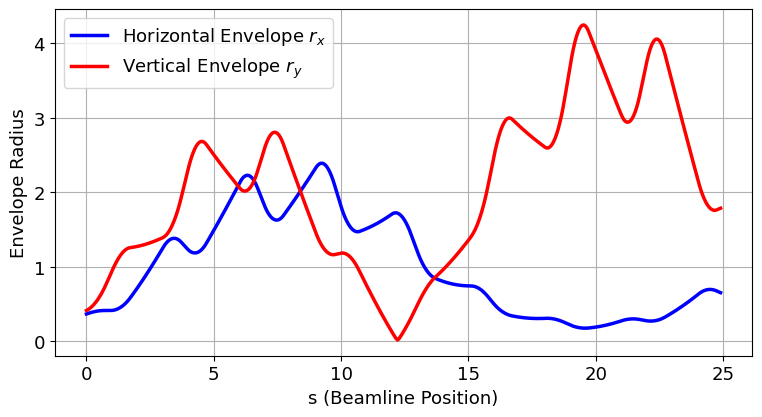

In [315]:
# focusing_params = generate_focusing_paramsperiodic_solenoid()
# print(focusing_params)
plt.rcParams.update({'font.size': 13})

# Plot the data
plt.figure(figsize=(9, 4.5))
plt.plot(df.index, df['X'], lw=2.5, label="Horizontal Envelope $r_x$", color='b')
plt.plot(df.index, df['Y'], lw=2.5, label="Vertical Envelope $r_y$", color='r')
plt.xlabel('s (Beamline Position)')
plt.ylabel('Envelope Radius')
# # plt.title('Solution of KV Envelope Equations')
plt.legend()
plt.grid(True)
# plt.savefig('KV_envelope_solution.png')
plt.show()

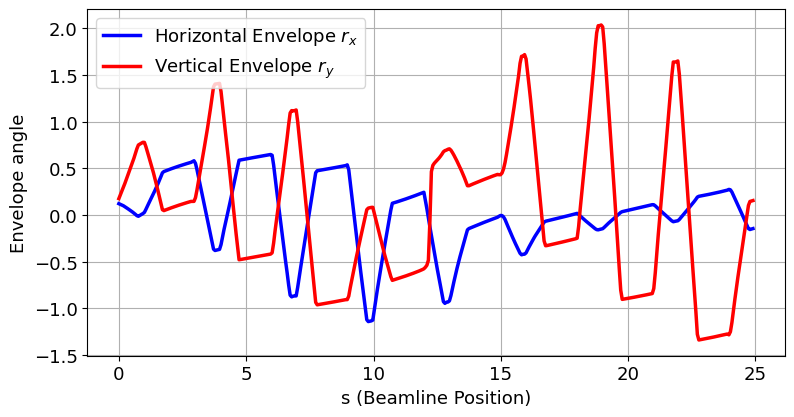

In [316]:
# Plot the data
plt.figure(figsize=(9, 4.5))
plt.plot(df.index, df['X_prime'], lw=2.5, label="Horizontal Envelope $r_x$", color='b')
plt.plot(df.index, df['Y_prime'], lw=2.5, label="Vertical Envelope $r_y$", color='r')
plt.xlabel('s (Beamline Position)')
plt.ylabel('Envelope angle')
# # plt.title('Solution of KV Envelope Equations')
plt.legend()
plt.grid(True)
# plt.savefig('KV_envelope_solution.png')
plt.show()

In [317]:
data_X = df.iloc[:, -4:]

In [318]:
# Clean the data
def clean_value(x):
    try:
        return float(str(x).replace('\xa0', '').replace(',', '.'))
    except ValueError:
        return np.nan

data_X = data_X.map(clean_value)
data_X = data_X.dropna()
data_X = data_X.astype(np.float64) 

In [319]:
data_X.head()

,X,X_prime,Y,Y_prime
s,,,,
0.000000,0.367116,0.122978,0.414300,0.177231
0.059005,0.374176,0.115679,0.425929,0.217550
0.118009,0.380793,0.108867,0.439934,0.256813
0.177014,0.386978,0.100788,0.456279,0.297164
0.236019,0.392622,0.090544,0.475074,0.339835


## Multivariate LSTM Forecast Model

In [320]:
# Standardize the data
scaler = MinMaxScaler()
data_X_scaled = scaler.fit_transform(data_X)

In [321]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.seq_length], self.data[idx+self.seq_length])

In [322]:
# split into train and test sets
train_size = int(len(data_X_scaled) * 0.85)
test_size = len(data_X_scaled) - train_size
train, test = data_X_scaled[0:train_size,:], data_X_scaled[train_size:len(data_X_scaled),:]
print(len(train), len(test))

359 64


In [323]:
train_df = data_X.iloc[:train_size]
test_df = data_X.iloc[train_size:]
# Paramters
seq_length = 3
batch_size = 16

# Data Preparation
dataset_train = TimeSeriesDataset(train, seq_length)
dataset_test = TimeSeriesDataset(test, seq_length)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

## Create the model

In [324]:
# LSTM-Attention-LSTM
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size, seq_length)
        self.softmax = nn.Softmax(dim=1)
        self.attn_combine = nn.Linear(hidden_size + hidden_size, hidden_size)

    def forward(self, hidden, encoder_outputs):
        attn_weights = self.softmax(self.attn(hidden))
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        output = torch.cat((hidden, attn_applied.squeeze(1)), 1)
        output = self.attn_combine(output)
        return output, attn_weights

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm1(x, (h0, c0))

        attn_output, _ = self.attention(out[:, -1, :], out)
        attn_output = attn_output.unsqueeze(1)

        out, _ = self.lstm2(attn_output, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [325]:
# Hyperparameters
input_size = data_X_scaled.shape[1]
hidden_size = 4
num_layers = 1
output_size = data_X_scaled.shape[1]
num_epochs = 100
learning_rate = 0.00875

In [326]:
# Optimizer
model = LSTMAttentionModel(input_size, hidden_size, num_layers, output_size).to('cpu')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Model training

In [327]:
# Model training

losses = []

for epoch in range(num_epochs):
    for sequences, targets in dataloader_train:
        sequences = sequences.to('cpu').float()
        targets = targets.to('cpu').float()

        outputs = model(sequences)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    losses.append(loss.item())

Epoch [10/100], Loss: 0.0204
Epoch [20/100], Loss: 0.0107
Epoch [30/100], Loss: 0.0050
Epoch [40/100], Loss: 0.0043
Epoch [50/100], Loss: 0.0008
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0004
Epoch [90/100], Loss: 0.0005
Epoch [100/100], Loss: 0.0002


In [328]:
# Prepare data for the prediction
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

In [329]:
# Prediction
model.eval()
with torch.no_grad():
    future_steps = 10
    sequences_train = create_sequences(train, seq_length)
    sequences_test = create_sequences(test, seq_length)

    sequences_train = torch.tensor(sequences_train).to('cpu').float()
    sequences_test = torch.tensor(sequences_test).to('cpu').float()

    predictions_train = model(sequences_train).cpu().numpy()
    predictions_test = model(sequences_test).cpu().numpy()

    predictions_train = scaler.inverse_transform(predictions_train)
    predictions_test = scaler.inverse_transform(predictions_test)

    forecast_input = data_X_scaled[-seq_length:]
    forecast_input = torch.tensor(forecast_input).unsqueeze(0).to('cpu').float()
    future_predictions = []
    for _ in range(future_steps):
        pred = model(forecast_input)
        future_predictions.append(pred.cpu().numpy())
        forecast_input = torch.cat((forecast_input[:, 1:, :], pred.unsqueeze(0)), dim=1)

    future_predictions = np.concatenate(future_predictions, axis=0)
    future_predictions = scaler.inverse_transform(future_predictions)

## Find the confidence interval

In [330]:
# CI
errors_train = train_df.values[-len(predictions_train):] - predictions_train
std_dev_train = np.std(errors_train, axis=0)
confidence_interval_train = 1.96 * std_dev_train

# CI
errors_test = test_df.values[-len(predictions_test):] - predictions_test
std_dev_test = np.std(errors_test, axis=0)
confidence_interval_test = 1.96 * std_dev_test

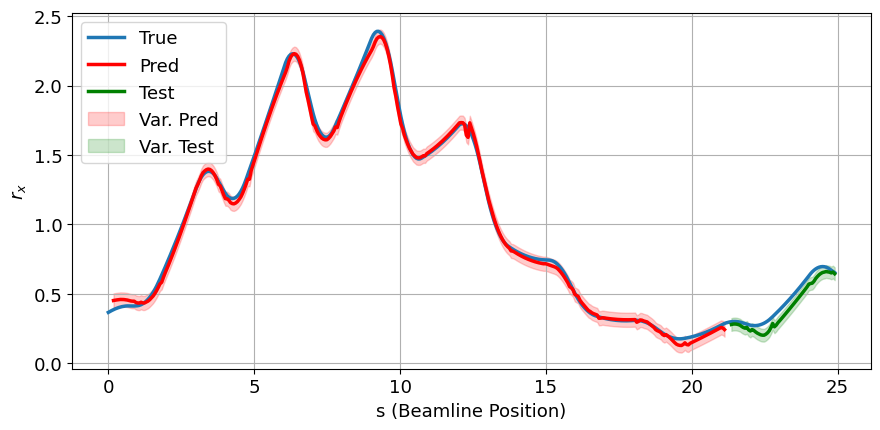

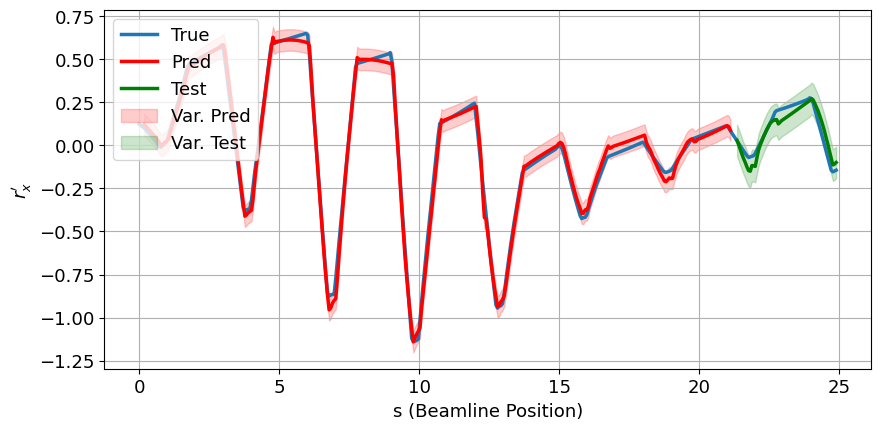

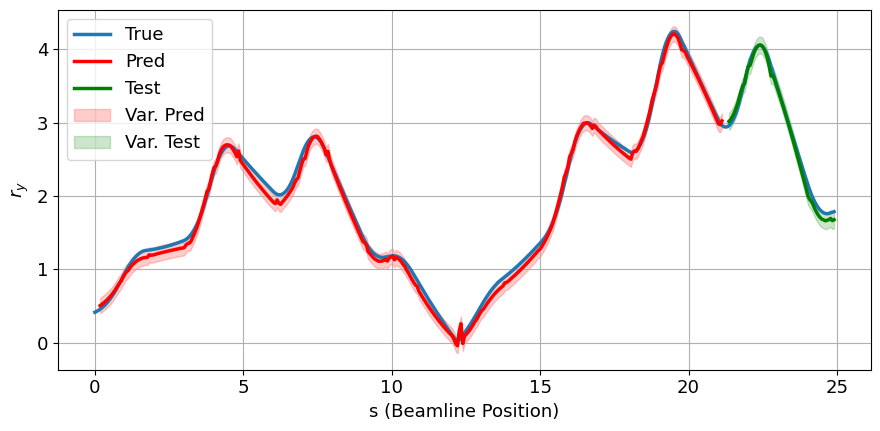

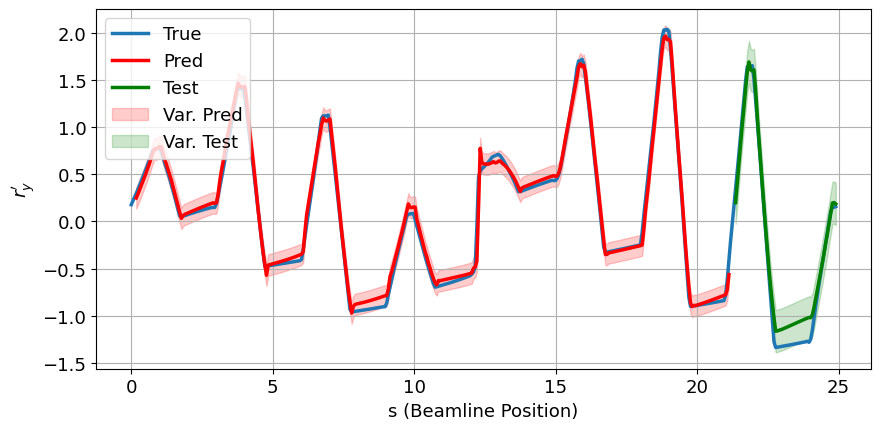

In [331]:
# Loop through each column and create separate figures

ppp = ['$r_x$','$r_x\'$','$r_y$','$r_y\'$']

plt.rcParams.update({'font.size': 13})
for i, column in enumerate(data_X.columns):
    plt.figure(figsize=(9, 4.5))  # Create a new figure for each column
    
    # Plot true values
    plt.plot(data_X.index, data_X[column], label='True', linewidth=2.5)
    
    # Plot predicted values for train and test
    plt.plot(train_df.index[-len(predictions_train):], predictions_train[:, i], label='Pred', color='red', linewidth=2.5)
    plt.plot(test_df.index[-len(predictions_test):], predictions_test[:, i], label='Test', color='green', linewidth=2.5)
    
    # Add confidence intervals
    plt.fill_between(train_df.index[-len(predictions_train):],
                     predictions_train[:, i] - confidence_interval_train[i],
                     predictions_train[:, i] + confidence_interval_train[i],
                     color='red', alpha=0.2, label='Var. Pred')
    plt.fill_between(test_df.index[-len(predictions_test):],
                     predictions_test[:, i] - confidence_interval_test[i],
                     predictions_test[:, i] + confidence_interval_test[i],
                     color='green', alpha=0.2, label='Var. Test')
    
    # Add title, legend, and formatting
    plt.xlabel('s (Beamline Position)')
    plt.ylabel(f'{ppp[i]}')
    # plt.title(f'{ppp[i]}')
    plt.legend(loc='upper left')
    # plt.tick_params(axis='both', which='major', labelsize=14, width=2)
    plt.grid('on')
    
    # Show the figure
    plt.tight_layout()
    plt.show()

## Loss

Text(0, 0.5, 'Loss')

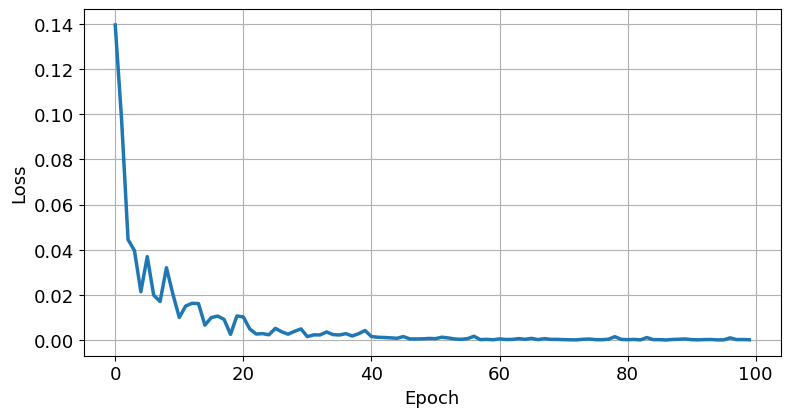

In [332]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(9, 4.5))
plt.plot(losses,linewidth=2.5)
plt.grid('on')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [333]:
# Specify the file name
file_name = 'data/sample_2.csv'

# Read the CSV file
try:
    # Load the CSV file into a DataFrame
    df2 = pd.read_csv(file_name)
    
    # Display the first few rows of the DataFrame
    print("CSV file loaded successfully. Here is a preview:")
    print(df2.head())
except FileNotFoundError:
    print(f"The file '{file_name}' was not found. Please check the file name or its location.")
except Exception as e:
    print(f"An error occurred: {e}")

data_X2 = df2.iloc[:, -4:]

# Normalisation des données
scaler = MinMaxScaler()
data_X2_scaled = scaler.fit_transform(data_X2)

CSV file loaded successfully. Here is a preview:
          s  quadrupole_param_1  quadrupole_param_2         X   X_prime  \
0  0.000000            1.031856           -0.988925  0.479697  0.090111   
1  0.059005            0.968009           -0.994433  0.484554  0.074839   
2  0.118009            0.988063           -0.977774  0.488484  0.057847   
3  0.177014            1.031231           -1.008751  0.491357  0.040049   
4  0.236019            1.044668           -0.992041  0.493240  0.023818   

          Y   Y_prime  
0  0.465647  0.136209  
1  0.474859  0.175675  
2  0.486422  0.216812  
3  0.500471  0.258906  
4  0.516952  0.299726  


In [334]:
# Prévisions
model.eval()
with torch.no_grad():
    sequences_test = create_sequences(data_X2_scaled, seq_length)
    sequences_test = torch.tensor(sequences_test).to('cpu').float()
    predictions_test = model(sequences_test).cpu().numpy()
    predictions_test = scaler.inverse_transform(predictions_test)

# Calcul de l'intervalle de confiance
errors_test = data_X2.values[-len(predictions_test):] - predictions_test
std_dev_test = np.std(errors_test, axis=0)
confidence_interval_test = 1.96 * std_dev_test

In [335]:
def plot_true_pred(y_true,y_pred):
    plt.figure(figsize=(5,4.5))
    plt.scatter(y_true, y_pred, c='blue', alpha=0.3)
    plt.plot([0,3],[0,3], c='red', linewidth=3)
    plt.xlim([0,3])
    plt.ylim([0,3])
    plt.grid(True)
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    # plt.title('True vs Predicted values')
    plt.show()

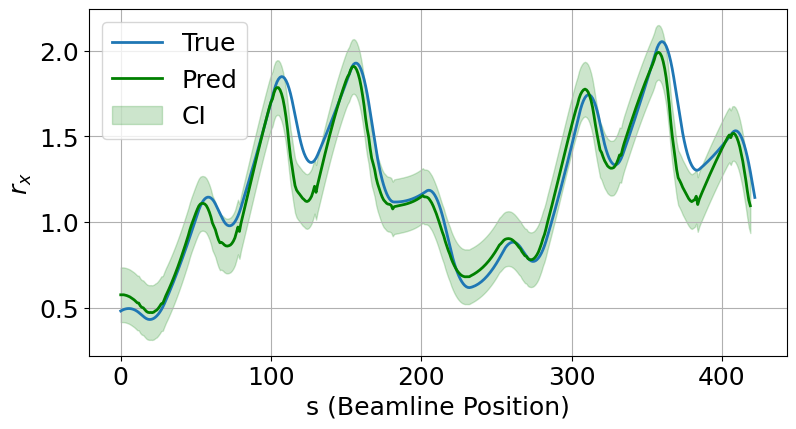

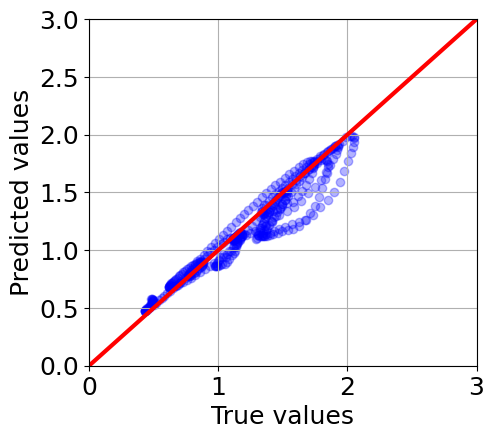

<Figure size 640x480 with 0 Axes>

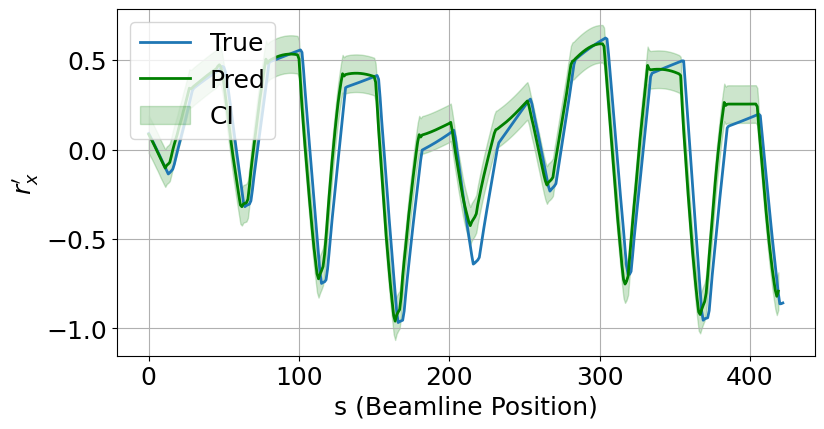

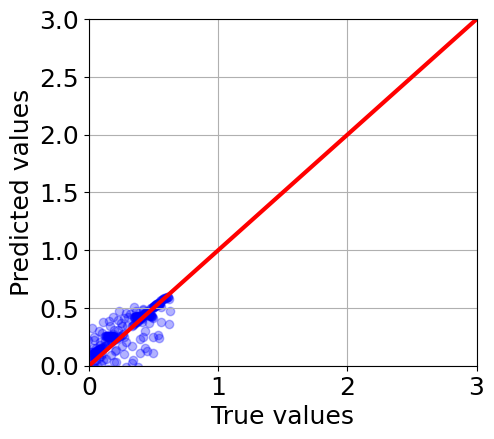

<Figure size 640x480 with 0 Axes>

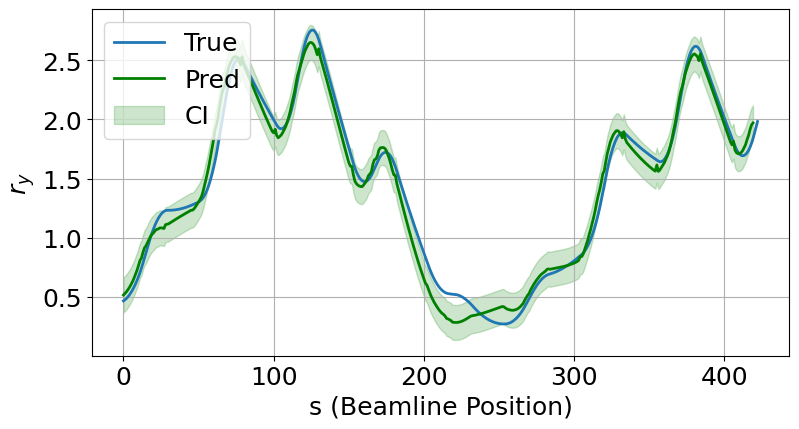

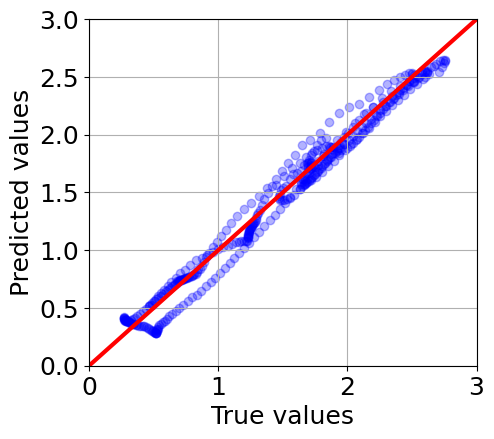

<Figure size 640x480 with 0 Axes>

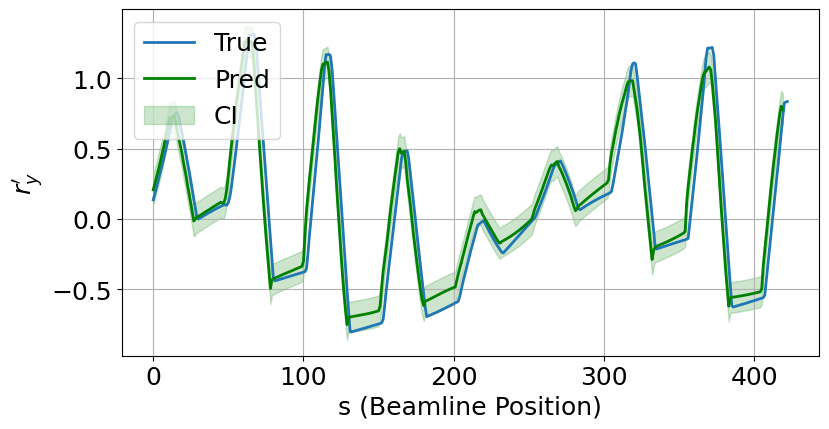

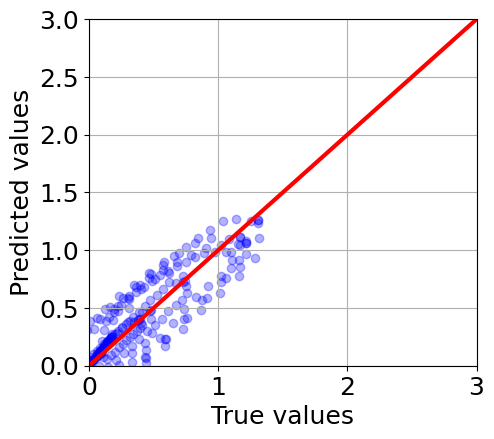

<Figure size 640x480 with 0 Axes>

In [ ]:
# Loop through each column and create separate figures

plt.rcParams.update({'font.size': 21})
for i, column in enumerate(data_X2.columns):
    plt.figure(figsize=(9, 4.5))  # Create a new figure for each column
    
    # Plot true values
    plt.plot(data_X2.index, data_X2[column], label='True', linewidth=2)
    
    # Plot predicted values  test
    plt.plot(data_X2.index[:len(predictions_test)], predictions_test[:, i], label='Pred', color='green', linewidth=2)
    
    # Add confidence intervals
    plt.fill_between(data_X2.index[:len(predictions_test)],
                     predictions_test[:, i] - confidence_interval_test[i],
                     predictions_test[:, i] + confidence_interval_test[i],
                     color='green', alpha=0.2, label='CI')
    
    # Add title, legend, and formatting
    plt.xlabel('s (Beamline Position)')
    # plt.title(f'{column}')
    plt.ylabel(f'{ppp[i]}')
    plt.legend(loc='upper left')
    # plt.tick_params(axis='both', which='major', labelsize=14, width=2)
    plt.grid('on')

    plot_true_pred(data_X2[column][:len(predictions_test)],predictions_test[:, i])
    
    # Show the figure
    plt.tight_layout()
    plt.show()